# **Analiza Czasu Trwania**
## Modele Parametryczne (Bayes)

In [1]:
import warnings
from typing import List

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
import xgboost as xgb
from lifelines import KaplanMeierFitter
from numba import NumbaDeprecationWarning
from pymc.sampling.jax import sample_numpyro_nuts
from scipy.stats import skew
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv

warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

In [2]:
# Constants
DRAWS=1000
TUNE=1000
CHAINS=4
TARGET_ACCEPT=0.95

In [3]:
backblaze_df = pl.read_parquet(
    "/Users/robertgawrylczyk/Documents/SGH/SM/Big Data/ACT/_backblaze_data_2024_agg_filtered.parquet"
)

In [4]:
# Labels count
backblaze_df['event'].value_counts()

shape: (2, 2)
┌───────┬────────┐
│ event ┆ count  │
│ ---   ┆ ---    │
│ i32   ┆ u32    │
╞═══════╪════════╡
│ 1     ┆ 3798   │
│ 0     ┆ 244307 │
└───────┴────────┘

In [5]:
# Features List
initial_features = [
    "smart_1_raw",
    "smart_3_raw",
    "smart_4_raw",
    "smart_5_raw",
    "smart_7_raw",
    "smart_9_raw",
    "smart_10_raw",
    "smart_12_raw",
    "smart_187_flag",
    "smart_188_flag",
    "smart_192_raw",
    "smart_193_raw",
    "smart_194_avg_temp",
    "smart_197_flag",
    "smart_198_raw",
    "smart_199_raw",
]

## Functions

In [6]:
# auto log transform
def auto_transform(
    df: pl.DataFrame, features: List[str] = [], skew_threshold: float = 1.0
) -> pl.DataFrame:
    transformed_exprs = []
    new_features = []

    for col in df.columns:
        values = df[col].to_numpy()
        if not np.issubdtype(values.dtype, np.number):
            transformed_exprs.append(pl.col(col))
            continue
        col_skew = skew(values[~np.isnan(values)])
        if (col_skew > skew_threshold) and (col in features) and ("flag" not in col):
            print(f"Skewed: {col} (skew={col_skew:.2f})")
            new_col = col + "_log"
            transformed_exprs.append(pl.col(col).log1p().alias(new_col))
            new_features.append(new_col)
        else:
            transformed_exprs.append(pl.col(col))
            if col in features:
                new_features.append(col)

    return df.select(transformed_exprs), new_features
    
# Time dependent AUC/PRAUC
def time_auc(
    metric_func, y_time, y_event, predicted_risk, times, title="", y_axis_label=""
):
    auc_scores = []
    for t in times:
        mask = y_time <= t
        if np.sum(mask) == 0:
            auc_scores.append(np.nan)
            continue

        y_bin = (y_time <= t) & (y_event == 1)
        try:
            auc = metric_func(y_bin, predicted_risk)
            auc_scores.append(auc)
        except ValueError:
            auc_scores.append(np.nan)

    # Chart
    plt.figure(figsize=(10, 5))
    plt.plot(times, auc_scores, marker="o")
    plt.xlabel("Czas (t)")
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

### Log transformation for skewed variables

In [7]:
# Transform skewed variables
df, features = auto_transform(df=backblaze_df, features=initial_features)
df = df.to_pandas()

Skewed: smart_4_raw (skew=46.47)
Skewed: smart_5_raw (skew=22.80)
Skewed: smart_7_raw (skew=496.03)
Skewed: smart_10_raw (skew=498.10)
Skewed: smart_12_raw (skew=97.30)
Skewed: smart_192_raw (skew=333.10)
Skewed: smart_193_raw (skew=28.56)
Skewed: smart_198_raw (skew=217.72)
Skewed: smart_199_raw (skew=173.16)


### Correlation of features with survival time

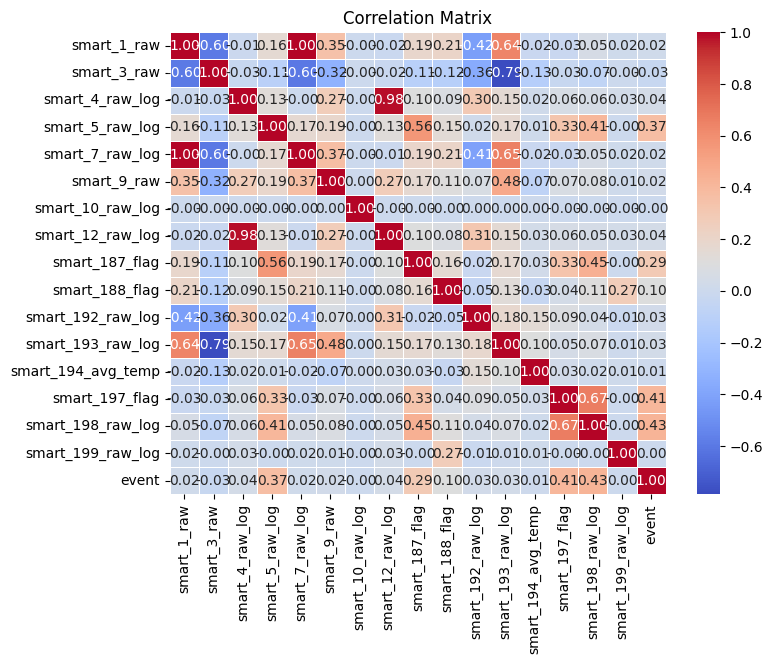

In [8]:
data = df[features + ["event"]]
# Pearson correlation
correlation_matrix = data.corr()
# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Feature selection (top 5) based on xgboost feature importance (label prediction)

In [9]:
# Features
X = df[features]
# Label
y = df["event"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Using the PR AUC metric due to the significant class imbalance.
params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
}

evals = [(dval, "eval")]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=False,
)

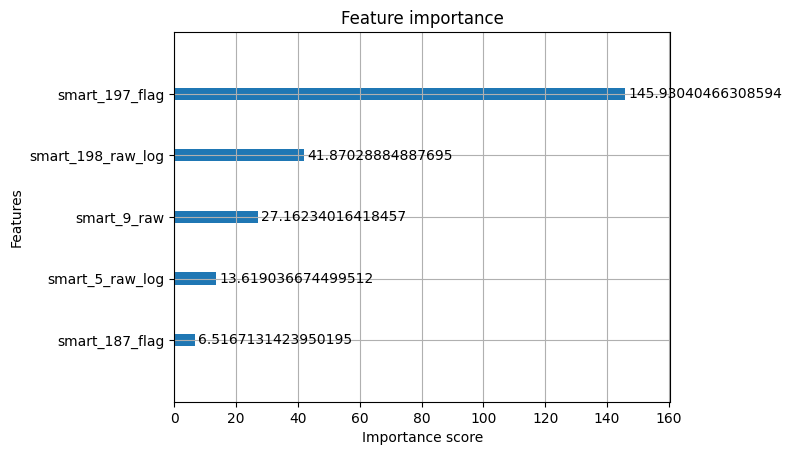

In [10]:
# Importance chart
xgb.plot_importance(model, importance_type='gain', max_num_features=5)
plt.show()

In [11]:
importance = model.get_score(importance_type="gain")
importance_df = pd.DataFrame.from_dict(
    importance, orient="index", columns=["importance"]
)
importance_df.sort_values(by="importance", ascending=False, inplace=True)
top_5 = importance_df.head(5)
top_5_features = list(top_5.index[0:5])
print(top_5)

                   importance
smart_197_flag     145.930405
smart_198_raw_log   41.870289
smart_9_raw         27.162340
smart_5_raw_log     13.619037
smart_187_flag       6.516713


### Features correlations (remove if corr > 0.9)

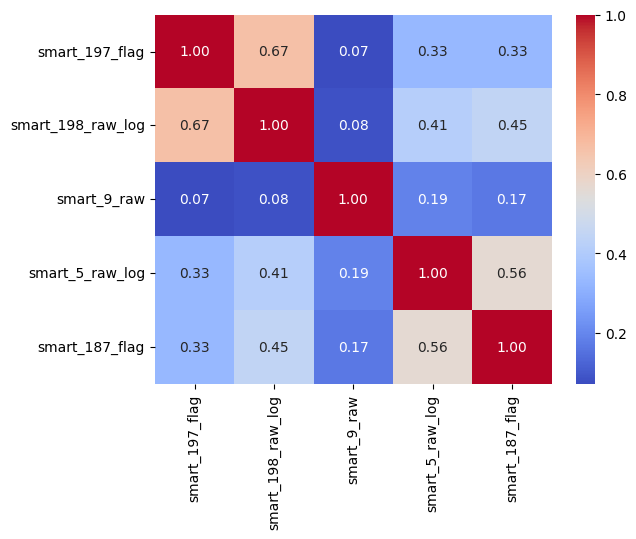

In [12]:
corr = X[top_5_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [13]:
final_features = top_5_features

# Final data preprocessing

In [14]:
df_event_0 = df[df["event"] == 0]
df_event_1 = df[df["event"] == 1]

# Sampling for event == 0 (for testing)
df_event_0_sampled = df_event_0.sample(n=10000, random_state=42)

# Merge
df = pd.concat([df_event_0_sampled, df_event_1], ignore_index=True)

In [15]:
# Removing t=0 (not supported by the Weibull distribution)
df = df[df['duration_days'] != 0]
# Choose final features
X = df[final_features]
y = df['duration_days'].values.astype(np.float32)
event = df['event'].values.astype(int)
# Features standarization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

### Kaplan Meier Estimator

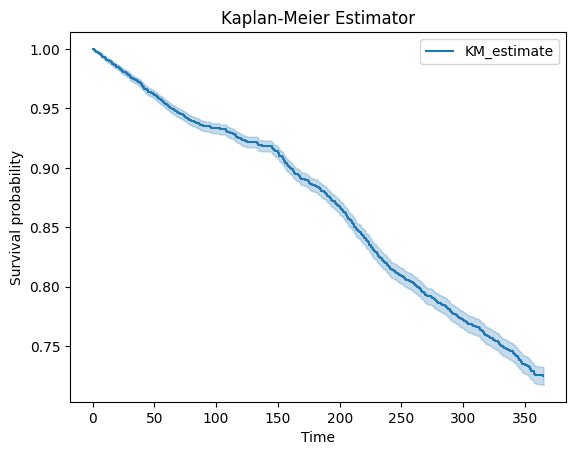

In [16]:
data = {
    'time': y,
    'event': event
}
# KME
df = pd.DataFrame(data)
kmf = KaplanMeierFitter()
kmf.fit(df['time'], event_observed=df['event'])
kmf.plot()
# Labels
plt.title('Kaplan-Meier Estimator')
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.show()

# Models with covariates

### Parametric model with covriates and Weibull distribution

In [17]:
with pm.Model() as model_weibull_covariates:
    # Betas
    beta = pm.Normal("beta", mu=0, sigma=3, shape=X_scaled.shape[1])
    intercept = pm.Normal("intercept", mu=5.7, sigma=5.0)
    alpha = pm.TruncatedNormal("alpha", mu=1.0, sigma=0.5, lower=0.1)

    linear = pm.math.dot(X_scaled, beta) + intercept
    lambda_ = pm.Deterministic("lambda_", pm.math.exp(linear))

    y_like = pm.Weibull("y_like", alpha=alpha, beta=lambda_, observed=y)

    # Log-likelihood
    log_likelihood = pm.Deterministic("log_likelihood", pm.logp(y_like, y))
    # Sampling
    trace_weibull_covariates = pm.sample(
        draws=DRAWS, tune=TUNE, chains=CHAINS, target_accept=TARGET_ACCEPT, return_inferencedata=True
    )

idata_weibull_covariates = trace_weibull_covariates.copy()
idata_weibull_covariates.sample_stats[
    "log_likelihood"
] = idata_weibull_covariates.posterior["log_likelihood"]

# WAIC
waic_result = az.waic(idata_weibull_covariates)
print(waic_result)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


Computed from 4000 posterior samples and 13795 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -82039.42   207.86
p_waic       13.23        -


In [18]:
az.summary(trace_weibull_covariates, var_names=["alpha", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    4.380  0.034   4.317    4.446      0.001    0.001    3834.0   
beta[0] -0.083  0.003  -0.088   -0.078      0.000    0.000    3276.0   
beta[1]  0.016  0.003   0.009    0.022      0.000    0.000    2972.0   
beta[2]  0.011  0.002   0.007    0.015      0.000    0.000    4521.0   
beta[3] -0.048  0.003  -0.054   -0.043      0.000    0.000    3529.0   
beta[4] -0.023  0.003  -0.029   -0.017      0.000    0.000    3596.0   

         ess_tail  r_hat  
alpha      2827.0    1.0  
beta[0]    2962.0    1.0  
beta[1]    2454.0    1.0  
beta[2]    2868.0    1.0  
beta[3]    2683.0    1.0  
beta[4]    2639.0    1.0

In [19]:
summary = az.summary(trace_weibull_covariates, var_names=["beta"], hdi_prob=0.9)
summary["HR"] = np.exp(summary["mean"])
summary["HR_hdi_5%"] = np.exp(summary["hdi_5%"])
summary["HR_hdi_95%"] = np.exp(summary["hdi_95%"])
summary.index = final_features  # jeśli masz listę nazw zmiennych

print(summary[["HR", "HR_hdi_5%", "HR_hdi_95%"]])

                         HR  HR_hdi_5%  HR_hdi_95%
smart_197_flag     0.920351   0.915761    0.924040
smart_198_raw_log  1.016129   1.010050    1.021222
smart_9_raw        1.011061   1.007025    1.014098
smart_5_raw_log    0.953134   0.947432    0.956954
smart_187_flag     0.977262   0.972388    0.982161


## MCMC Diagnostics

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

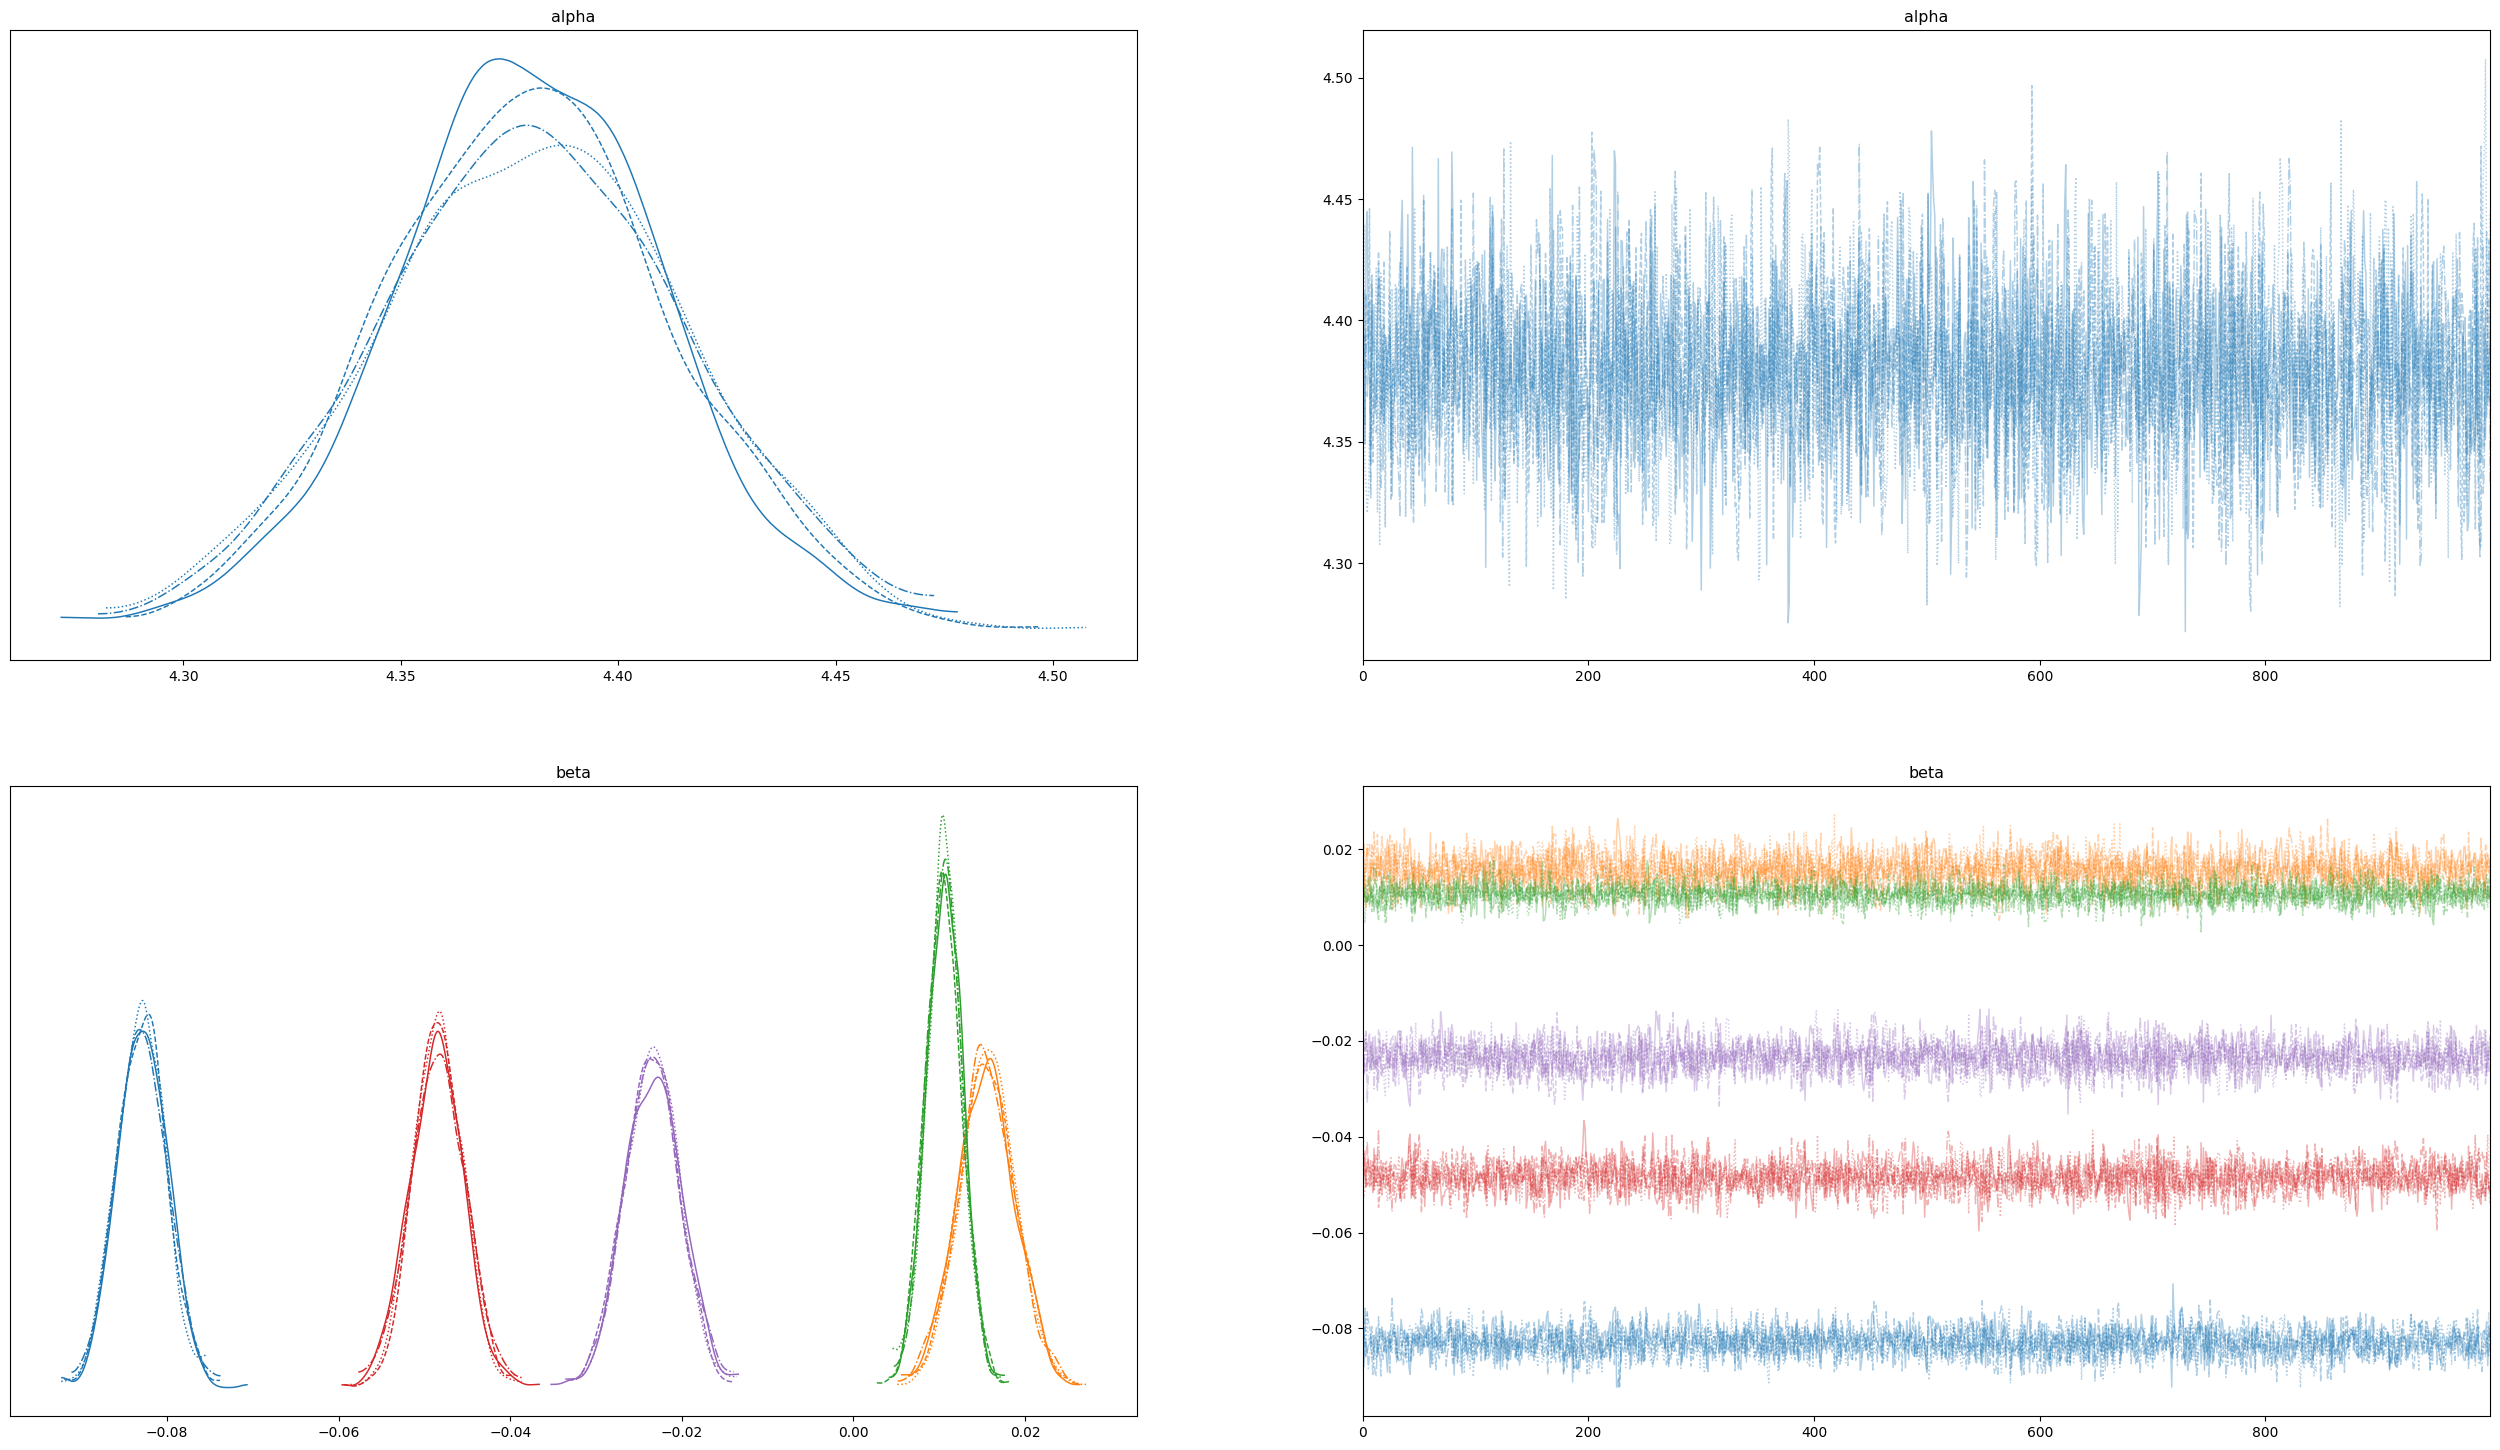

In [20]:
az.plot_trace(trace_weibull_covariates, figsize=(32, 18), var_names=["alpha", "beta"])

<Figure size 1000x500 with 0 Axes>

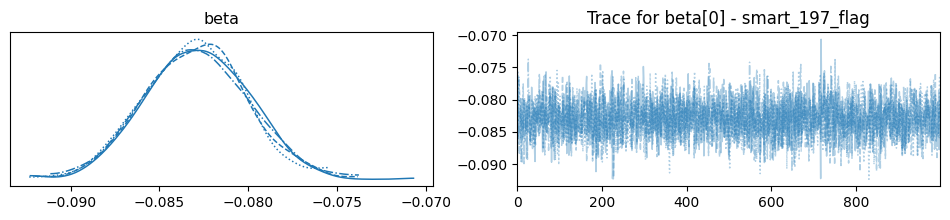

<Figure size 1000x500 with 0 Axes>

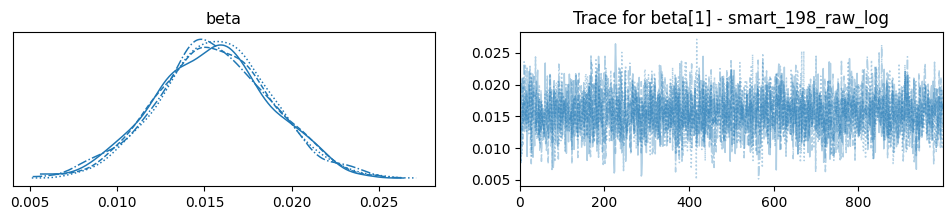

<Figure size 1000x500 with 0 Axes>

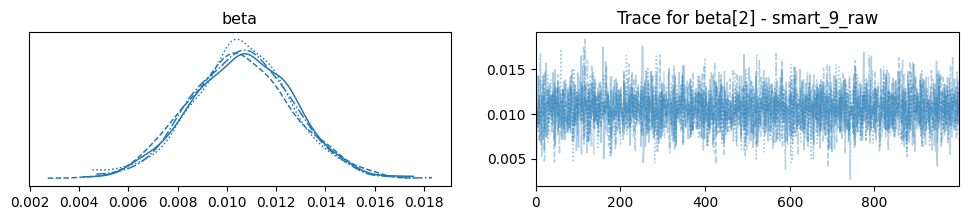

<Figure size 1000x500 with 0 Axes>

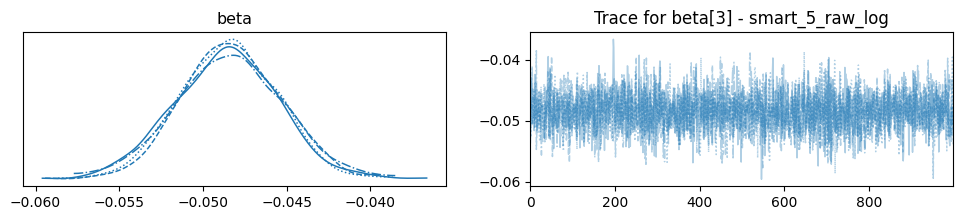

<Figure size 1000x500 with 0 Axes>

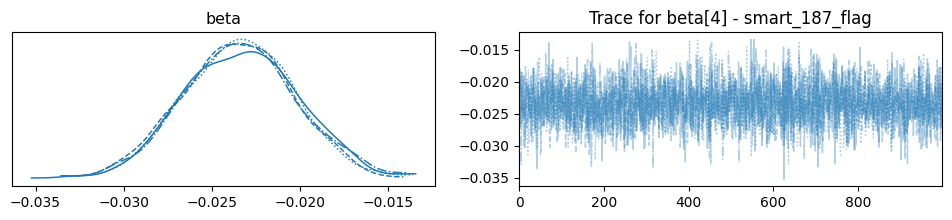

In [21]:
n_betas = trace_weibull_covariates.posterior["beta"].shape[2]

for beta_idx, feature_name in zip(range(n_betas), final_features):
    plt.figure(figsize=(10, 5))
    var_name = "beta"
    az.plot_trace(
        trace_weibull_covariates,
        var_names=[var_name],
        coords={"beta_dim_0": beta_idx},
    )
    plt.title(f"Trace for {var_name}[{beta_idx}] - {feature_name}")
    plt.show()

array([[<Axes: ylabel='beta\n1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\n2'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\n3'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='beta\n0', ylabel='beta\n4'>,
        <Axes: xlabel='beta\n1'>, <Axes: xlabel='beta\n2'>,
        <Axes: xlabel='beta\n3'>]], dtype=object)

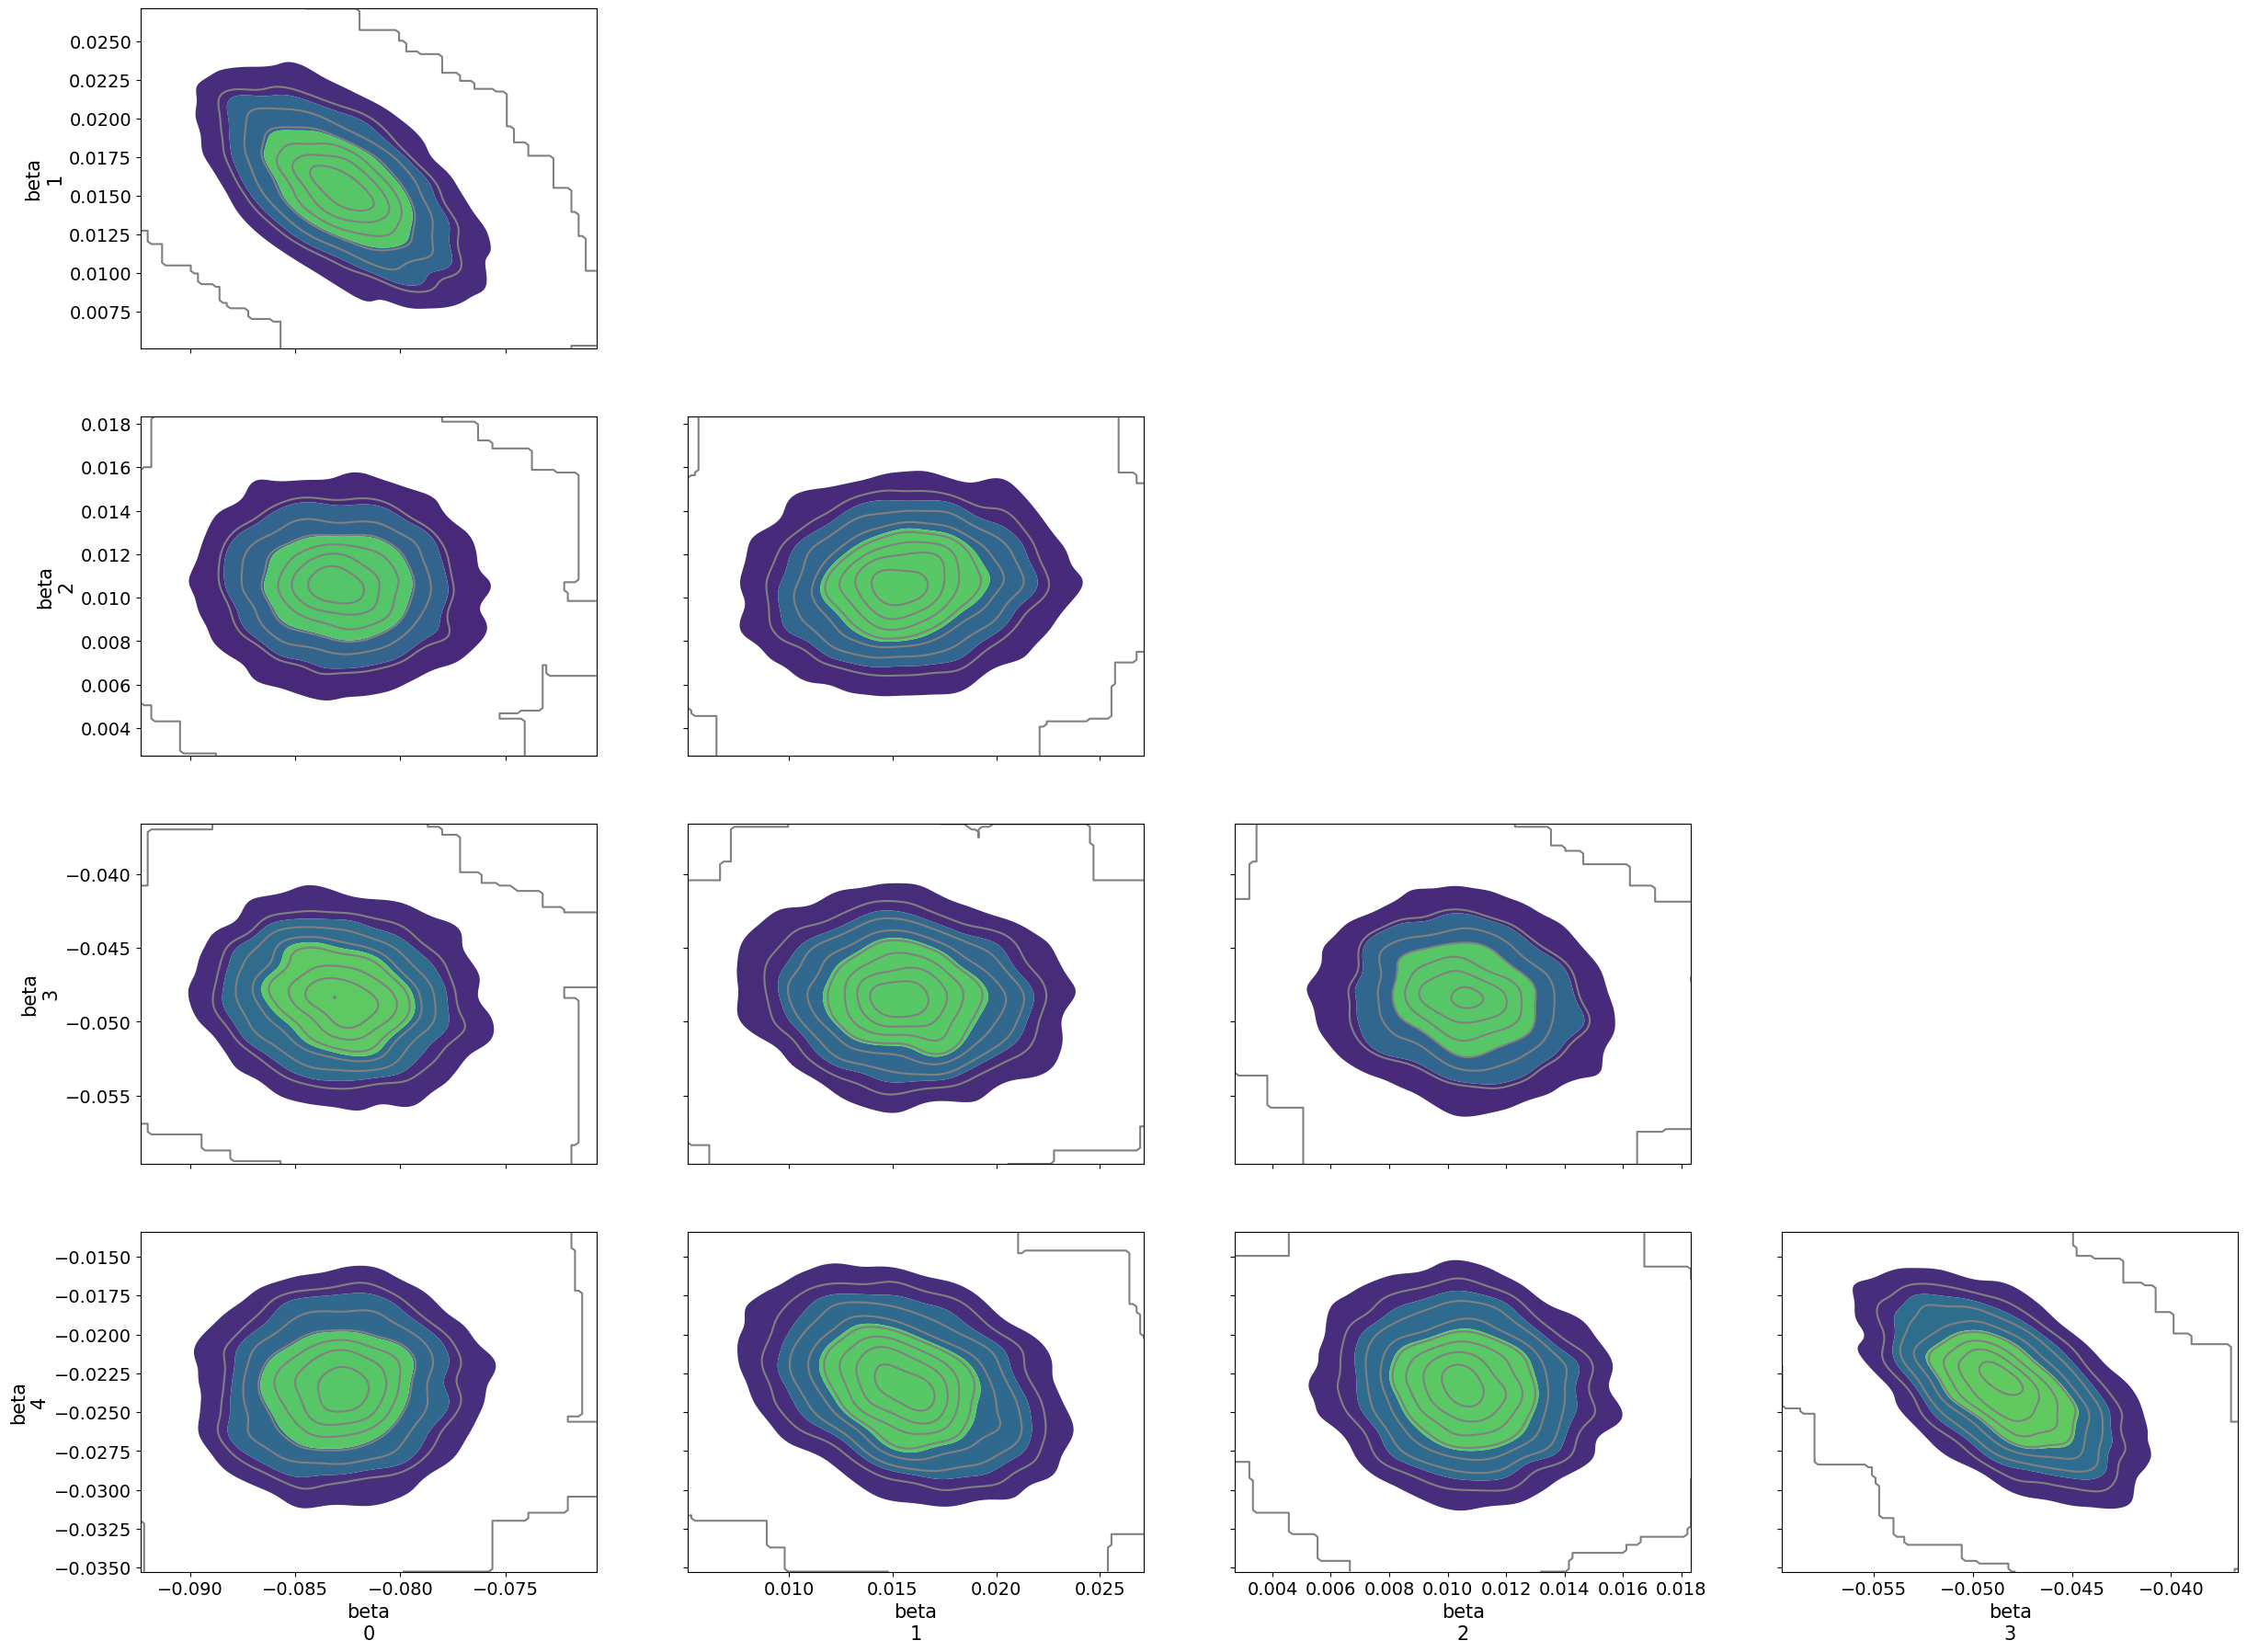

In [22]:
az.plot_pair(trace_weibull_covariates, var_names=["beta"], kind="kde", divergences=True)

## Model Performance

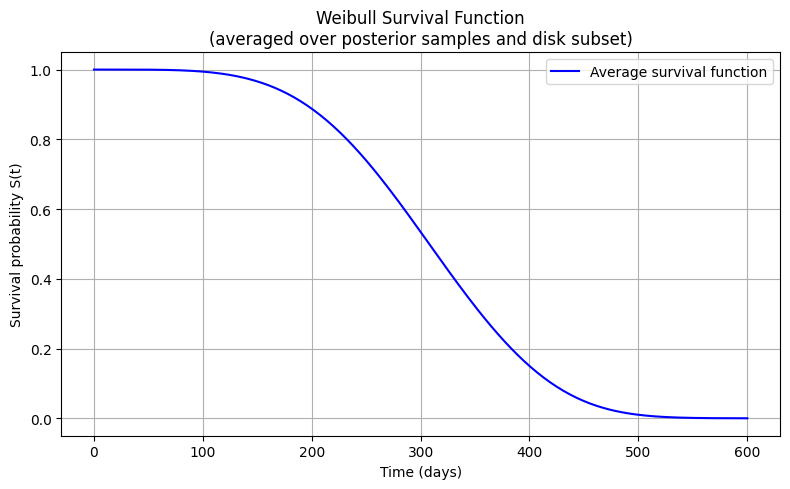

In [23]:
# Reshape lambda samples to (n_samples, n_observations)
lambda_samples = trace_weibull_covariates.posterior["lambda_"].values.reshape(
    -1, X_scaled.shape[0]
)

# Flatten alpha samples to shape (n_samples,)
alpha_samples = trace_weibull_covariates.posterior["alpha"].values.flatten()

# Subsample the observations for performance
n_obs_subset = 1000  # Adjust depending on available RAM and performance
subset_idx = np.random.choice(X_scaled.shape[0], size=n_obs_subset, replace=False)
lambda_subset = lambda_samples[:, subset_idx]  # Shape: (n_samples, n_obs_subset)

# Define time grid (e.g., from 0.1 to 600 days)
t_range = np.linspace(0.1, 600, 200)

# Compute survival function S(t) for each t
# Averaged over all posterior samples and subset observations

S_t_all = []

for t in t_range:
    # Weibull survival function: S(t) = exp(-(t / λ)^α)
    S_t = np.exp(- (t / lambda_subset) ** alpha_samples[:, None])  # Shape: (n_samples, n_obs_subset)
    S_t_mean = S_t.mean()  # Average over samples and subset observations
    S_t_all.append(S_t_mean)
    
# Plot the averaged survival function
plt.figure(figsize=(8, 5))
plt.plot(t_range, S_t_all, label="Average survival function", color="blue")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability S(t)")
plt.title("Weibull Survival Function\n(averaged over posterior samples and disk subset)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

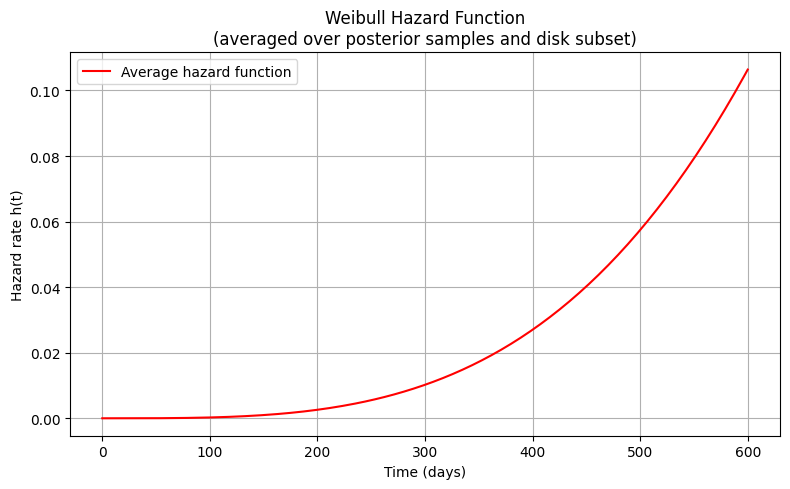

In [24]:
lambda_samples = trace_weibull_covariates.posterior["lambda_"].values.reshape(
    -1, X_scaled.shape[0]
)
alpha_samples = trace_weibull_covariates.posterior["alpha"].values.flatten()

# Subsample for performance
n_obs_subset = 1000  # adjust based on available RAM
subset_idx = np.random.choice(X_scaled.shape[0], size=n_obs_subset, replace=False)
lambda_subset = lambda_samples[:, subset_idx]  # shape: (n_samples, 1000)

# alpha_samples: shape (n_samples,) remains unchanged

# Time grid
t_range = np.linspace(0.1, 600, 200)

# Compute average hazard function
h_t_all = []

for t in t_range:
    h_t = (alpha_samples[:, None] / lambda_subset) * (t / lambda_subset) ** (alpha_samples[:, None] - 1)
    h_t_mean = h_t.mean()
    h_t_all.append(h_t_mean)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(t_range, h_t_all, label="Average hazard function", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Hazard rate h(t)")
plt.title("Weibull Hazard Function\n(averaged over posterior samples and disk subset)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Hazard Ratios (HR) for each covariate

In [25]:
summary = az.summary(trace_weibull_covariates, var_names=["beta"], hdi_prob=0.9)
summary["HR"] = np.exp(summary["mean"])
summary["HR_hdi_5%"] = np.exp(summary["hdi_5%"])
summary["HR_hdi_95%"] = np.exp(summary["hdi_95%"])

summary.index = final_features
print(summary[["HR", "HR_hdi_5%", "HR_hdi_95%"]])

                         HR  HR_hdi_5%  HR_hdi_95%
smart_197_flag     0.920351   0.915761    0.924040
smart_198_raw_log  1.016129   1.010050    1.021222
smart_9_raw        1.011061   1.007025    1.014098
smart_5_raw_log    0.953134   0.947432    0.956954
smart_187_flag     0.977262   0.972388    0.982161


### Percentiles

In [26]:
percentiles = [0.1, 0.2, 0.5, 0.9, 0.99]

for p in percentiles:
    tp = lambda_samples * (-np.log(1 - p)) ** (1 / alpha_samples[:, None])  
    
    tp_median_per_sample = np.median(tp, axis=1)  #
    tp_global_median = np.median(tp_median_per_sample) 

    hdi_low = np.percentile(tp_median_per_sample, 2.5)
    hdi_high = np.percentile(tp_median_per_sample, 97.5)

    print(f"{int(p * 100)}% survival time: {tp_global_median:.2f} days (95% HDI: {hdi_low:.2f}–{hdi_high:.2f})")

10% survival time: 213.16 days (95% HDI: 211.12–215.19)
20% survival time: 252.99 days (95% HDI: 251.10–254.84)
50% survival time: 327.72 days (95% HDI: 326.01–329.45)
90% survival time: 431.05 days (95% HDI: 428.72–433.51)
99% survival time: 505.00 days (95% HDI: 501.51–508.63)


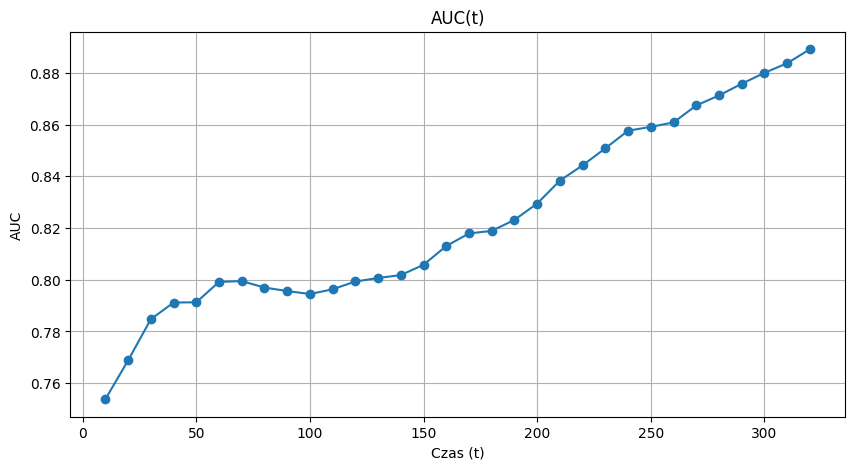

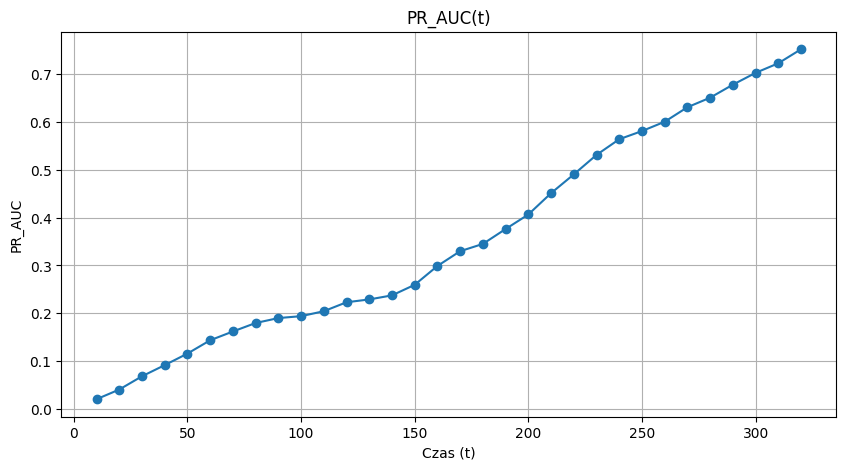

In [27]:
beta_samples = trace_weibull_covariates.posterior[
    "beta"
].values  # (chain, draw, beta_dim_0)

# Number of observations
n_obs = X_scaled.shape[0]
# Mean beta values across chains and samples (mean coefficient for each explanatory variable)
beta_mean = beta_samples.mean(axis=(0, 1))  
# Calculate lambda_pred for all observations
lambda_pred = np.exp(np.dot(X_scaled, beta_mean))
# Evaluate every 10 days up to the 90th percentile of survival time
t_max = np.percentile(y[event == 1], 90)
times = np.arange(10, t_max, 10)

# Time-dependent AUC using ROC AUC as the metric
time_auc(
    metric_func=roc_auc_score,
    y_time=y,
    y_event=event,
    predicted_risk=-lambda_pred,
    times=times,
    title="AUC(t)",
    y_axis_label="AUC",
)
# Time-dependent AUC using Average Precision (PR AUC) as the metric
time_auc(
    metric_func=average_precision_score,
    y_time=y,
    y_event=event,
    predicted_risk=-lambda_pred,
    times=times,
    title="PR_AUC(t)",
    y_axis_label="PR_AUC",
)

# Baseline Models

## Weibull

In [28]:
with pm.Model() as model_weibull_baseline:
    # Input Data
    y_data = pm.Data("y", y)
    event_data = pm.Data("event", event)
    # Parameters
    alpha = pm.Gamma("alpha", alpha=2.0, beta=1.0)  # Shape
    lambda_ = pm.Gamma("lambda_", alpha=2.0, beta=1.0)  # Scale
    # Weibull Model
    y_like = pm.Weibull("y_like", alpha=alpha, beta=lambda_, observed=y_data)
    # Log likelihood
    log_likelihood = pm.Deterministic("log_likelihood", pm.logp(y_like, y))
    # Sampling
    trace_weibull_baseline = pm.sample(
        draws=DRAWS,
        tune=TUNE,
        chains=CHAINS,
        target_accept=TARGET_ACCEPT,
    )

idata_weibull_baseline = trace_weibull_baseline.copy()
idata_weibull_baseline.sample_stats[
    "log_likelihood"
] = idata_weibull_baseline.posterior["log_likelihood"]

waic_result = az.waic(idata_weibull_baseline)
print(waic_result)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, lambda_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


Computed from 4000 posterior samples and 13795 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -83402.20   200.37
p_waic        6.95        -


## Exponential

In [42]:
with pm.Model() as model_exponential_baseline:
    # Input Data
    y_data = pm.Data("y", y)
    event_data = pm.Data("event", event)
    # Scale parameter
    lambda_ = pm.Gamma("lambda_", alpha=1.0, beta=1.0)
    # Exponential Model
    y_like = pm.Exponential("y_like", lam=lambda_, observed=y_data)
    # Log likelihood
    log_likelihood = pm.Deterministic("log_likelihood", pm.logp(y_like, y))

    trace_exponential_baseline = pm.sample(
        draws=DRAWS,
        tune=TUNE,
        chains=CHAINS,
        target_accept=0.95,
    )

idata_exponential_baseline = trace_exponential_baseline.copy()
idata_exponential_baseline.sample_stats[
    "log_likelihood"
] = idata_exponential_baseline.posterior["log_likelihood"]

waic_result = az.waic(idata_exponential_baseline)
print(waic_result)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Computed from 4000 posterior samples and 13795 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -93234.42    35.17
p_waic        0.08        -


# MCMC Performance

In [30]:
az.summary(trace_exponential_baseline, var_names=["lambda_"])

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
lambda_  0.003  0.0   0.003    0.003        0.0      0.0    1729.0    1834.0   

         r_hat  
lambda_    1.0

array([[<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>]], dtype=object)

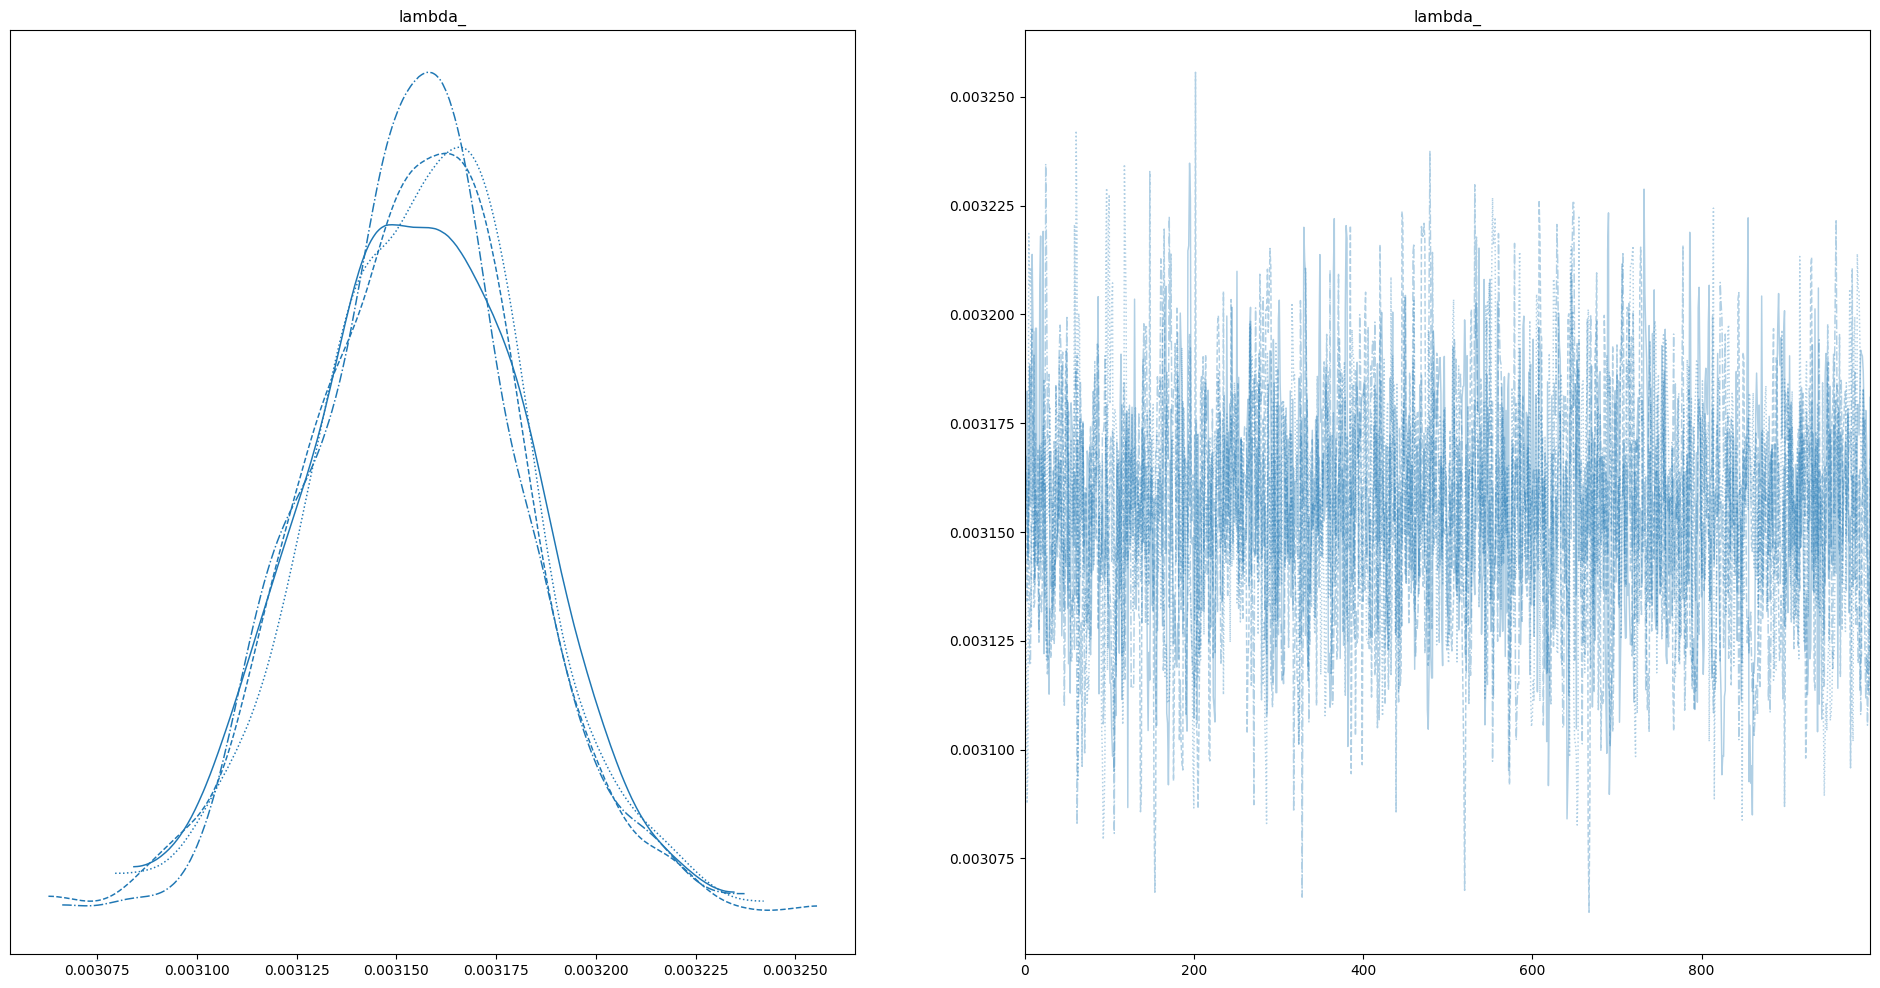

In [31]:
az.plot_trace(trace_exponential_baseline, figsize=(24, 12), var_names=["lambda_"])

## Model performance

In [32]:
# Extract posterior samples of lambda
lambda_samples = trace_exponential_baseline.posterior["lambda_"].values.flatten()
# Compute mean survival time (expected value of T)
mean_survival = 1 / lambda_samples
# Median and 95% credible intervals
mean_survival_median = np.median(mean_survival)
mean_survival_hdi = np.percentile(mean_survival, [2.5, 97.5])

lambda_median = np.median(lambda_samples)
lambda_hdi = np.percentile(lambda_samples, [2.5, 97.5])

# Print results
print(f"Mean survival time (E[T]): {mean_survival_median:.2f}")
print(f"95% credible interval for E[T]: {mean_survival_hdi[0]:.2f} – {mean_survival_hdi[1]:.2f}\n")

print(f"Constant hazard rate (λ): {lambda_median:.5f}")
print(f"95% credible interval for λ: {lambda_hdi[0]:.5f} – {lambda_hdi[1]:.5f}")

Mean survival time (E[T]): 316.84
95% credible interval for E[T]: 311.68 – 322.12

Constant hazard rate (λ): 0.00316
95% credible interval for λ: 0.00310 – 0.00321


In [43]:
# Extract posterior samples of lambda
lambda_samples = trace_exponential_baseline.posterior["lambda_"].values.flatten()

# Define percentiles
percentiles = [0.1, 0.2, 0.5, 0.9, 0.99]

print("Survival times at selected percentiles (posterior median across all samples):")
for p in percentiles:
    times = -np.log(1 - p) / lambda_samples  # shape: (n_samples,)
    median_time = np.percentile(times, 50)
    hdi_lower = np.percentile(times, 2.5)
    hdi_upper = np.percentile(times, 97.5)
    print(
        f"{int(p*100)}%: {median_time:.2f} days (95% HDI: {hdi_lower:.2f}–{hdi_upper:.2f})"
    )

Survival times at selected percentiles (posterior median across all samples):
10%: 33.39 days (95% HDI: 32.86–33.92)
20%: 70.71 days (95% HDI: 69.60–71.85)
50%: 219.64 days (95% HDI: 216.20–223.18)
90%: 729.61 days (95% HDI: 718.21–741.40)
99%: 1459.23 days (95% HDI: 1436.43–1482.80)


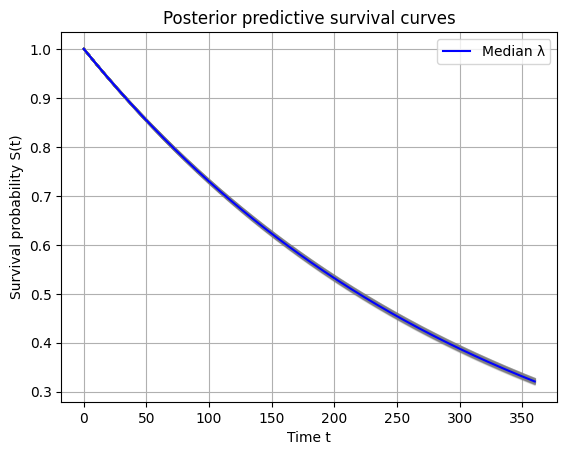

In [35]:
t_vals = np.linspace(0, 360, 200)
S_vals = [np.exp(-l * t_vals) for l in lambda_samples[np.random.choice(len(lambda_samples.flatten()), size=100)]]

for S in S_vals:
    plt.plot(t_vals, S, color='gray', alpha=0.2)

plt.plot(t_vals, np.exp(-np.median(lambda_samples) * t_vals), color='blue', label='Median λ')
plt.xlabel("Time t")
plt.ylabel("Survival probability S(t)")
plt.title("Posterior predictive survival curves")
plt.legend()
plt.grid(True)
plt.show()